In [1]:
suppressMessages({library(Seurat) 
library(SeuratData)
library(Signac)
library(EnsDb.Hsapiens.v86)
library(ggplot2)
library(cowplot)
library(GenomeInfoDb)
library(stringr)
library(patchwork)
library(SeuratDisk)
library(dplyr)
library(Matrix)
set.seed(1234)})

In [84]:
results_dir = "../../../results/Fig8-Corces2020_brain_scATAC/Fig8-apply_seurat_label_transfer/"
figures_dir = "../../../results/Fig8-Corces2020_brain_scATAC/Fig8-apply_seurat_label_transfer/figures/"

In [2]:
data_path = "/project/scATAC_analysis/10X_scATAC_HumanBrain_Corces2020/preprocessing/cellranger_atac_counts/cr_count_scatac_humanBrain_Corces2020_2022-09-29/outs/"

In [3]:
counts <- Read10X_h5(filename = paste(data_path,"filtered_peak_bc_matrix.h5", sep=""))
metadata <- read.csv(
  file = paste(data_path,"singlecell.csv", sep=""),
  header = TRUE,
  row.names = 1
)

chrom_assay <- CreateChromatinAssay(
  counts = counts,
  sep = c(":", "-"),
  fragments = paste(data_path,"fragments.tsv.gz", sep=""),
  min.cells = 10,
  min.features = 200
)

corces_brain <- CreateSeuratObject(
  counts = chrom_assay,
  assay = "peaks",
  meta.data = metadata
)

Computing hash



In [4]:
# extract gene annotations from EnsDb
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86)

# change to UCSC style since the data was mapped to hg38
seqlevelsStyle(annotations) <- 'UCSC'
genome(annotations) <- "hg38"

Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warn

In [5]:
# add the gene information to the object
Annotation(corces_brain) <- annotations

In [7]:
# compute nucleosome signal score per cell
corces_brain <- NucleosomeSignal(object = corces_brain)

# compute TSS enrichment score per cell
corces_brain <- TSSEnrichment(object = corces_brain, fast = FALSE)

# add blacklist ratio and fraction of reads in peaks
corces_brain$pct_reads_in_peaks <- corces_brain$peak_region_fragments / corces_brain$passed_filters * 100
corces_brain$blacklist_ratio <- corces_brain$blacklist_region_fragments / corces_brain$peak_region_fragments

Extracting TSS positions

Finding + strand cut sites

Finding - strand cut sites

Computing mean insertion frequency in flanking regions

Normalizing TSS score



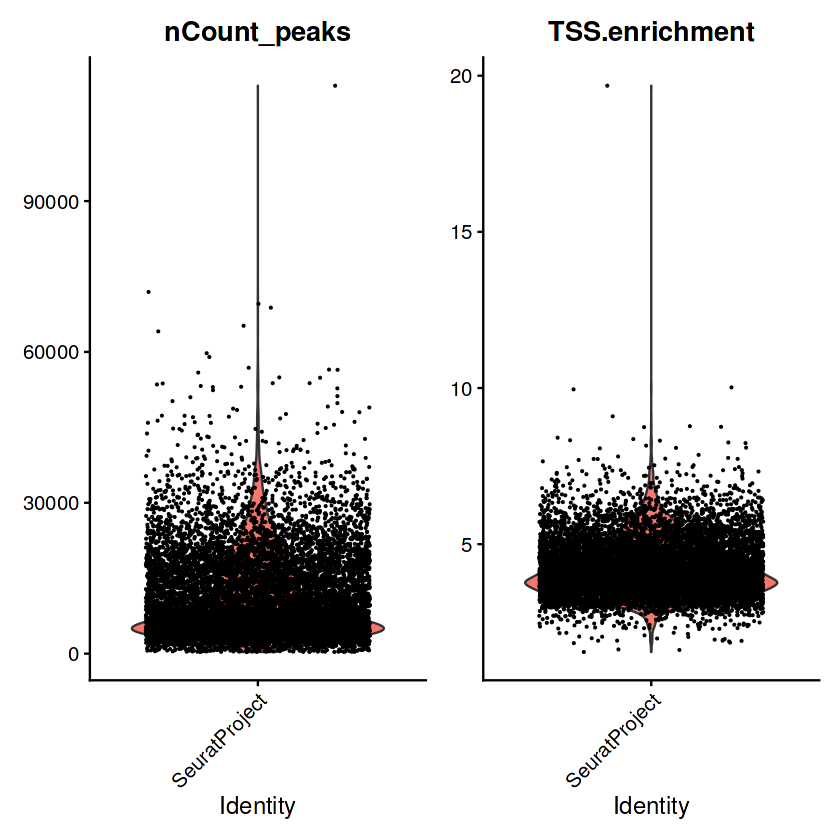

In [12]:
VlnPlot(
  object = corces_brain,
  features = c('nCount_peaks', 'TSS.enrichment'),
  pt.size = 0.1,
  ncol = 2
)

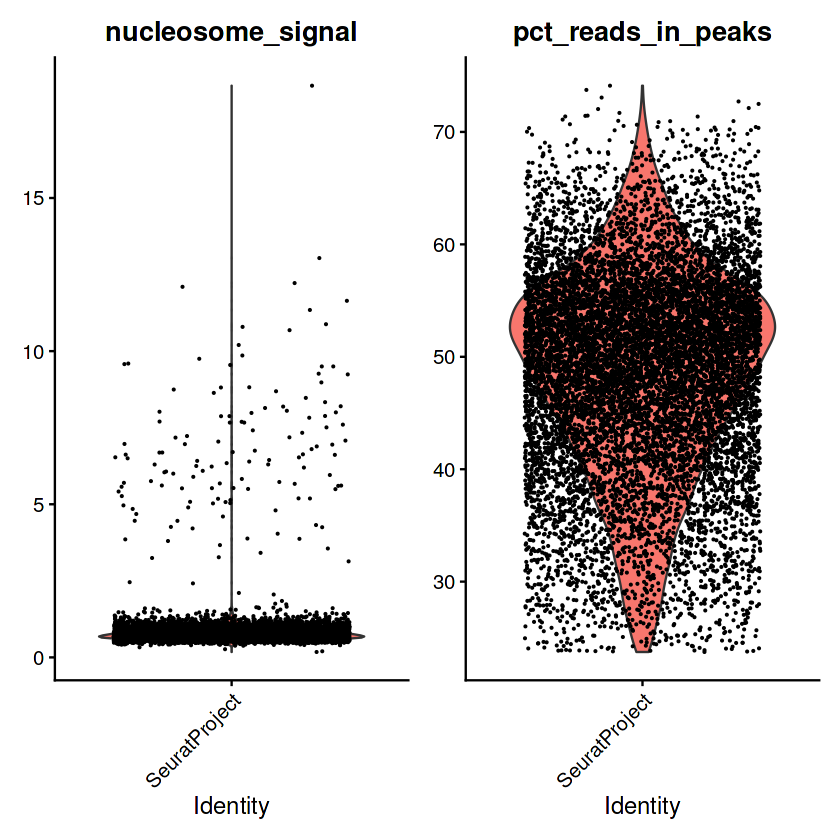

In [10]:
VlnPlot(
  object = corces_brain,
  features = c('nucleosome_signal', 'pct_reads_in_peaks'),
  pt.size = 0.1,
  ncol = 2
)

In [13]:
corces_brain <- subset(
  x = corces_brain,
  subset = nCount_peaks > 3000 &
    nCount_peaks < 30000 &
    pct_reads_in_peaks > 15 &
    blacklist_ratio < 0.05 &
    nucleosome_signal < 4 &
    TSS.enrichment > 3
)
corces_brain

An object of class Seurat 
184419 features across 9243 samples within 1 assay 
Active assay: peaks (184419 features, 0 variable features)
 2 layers present: counts, data

In [6]:
corces_brain <- RunTFIDF(corces_brain)
corces_brain <- FindTopFeatures(corces_brain, min.cutoff = 'q0')


Performing TF-IDF normalization



In [7]:
corces_brain <- RunSVD(corces_brain)

Running SVD

Scaling cell embeddings



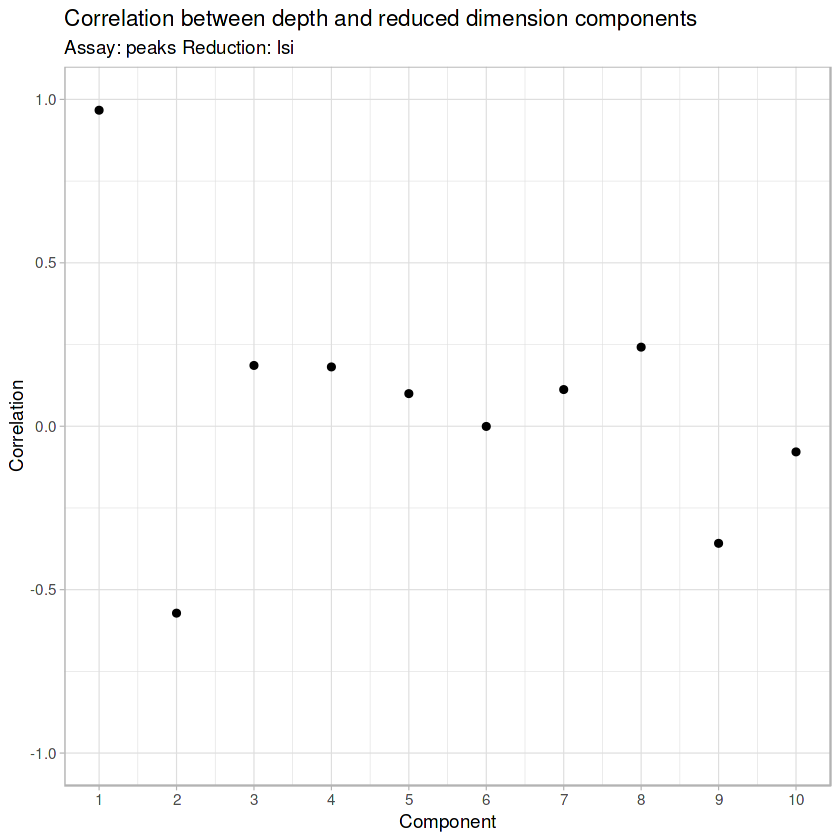

In [8]:
DepthCor(corces_brain)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
12:42:56 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

12:42:56 Read 10772 rows and found 29 numeric columns

12:42:56 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

12:42:56 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

12:42:58 Writing NN index file to 

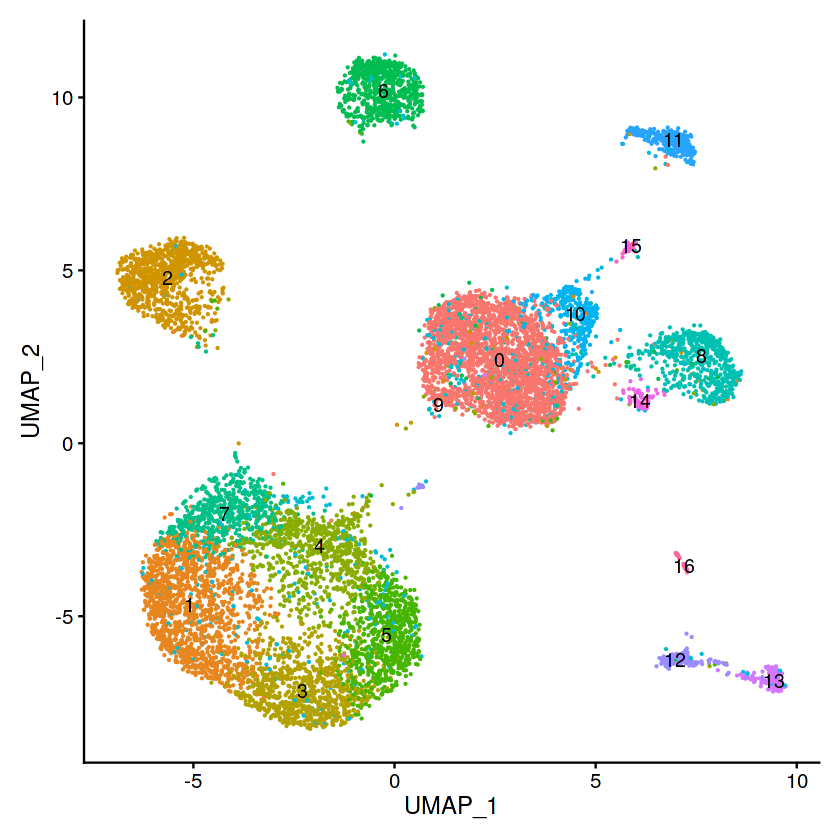

In [9]:
corces_brain <- RunUMAP(object = corces_brain, reduction = 'lsi', dims = 2:30)
corces_brain <- FindNeighbors(object = corces_brain, reduction = 'lsi', dims = 2:30)
corces_brain <- FindClusters(object = corces_brain, verbose = FALSE, algorithm = 3)
DimPlot(object = corces_brain, label = TRUE) + NoLegend()

In [11]:
gene.activities <- GeneActivity(corces_brain)
# add the gene activity matrix to the Seurat object as a new assay and normalize it
corces_brain[['RNA']] <- CreateAssayObject(counts = gene.activities)
corces_brain <- NormalizeData(
  object = corces_brain,
  assay = 'RNA',
  normalization.method = 'LogNormalize',
  scale.factor = median(corces_brain$nCount_RNA)
)

Extracting gene coordinates

Extracting reads overlapping genomic regions



### scATAC-seq annotation
We use Allen Brain span data as reference : https://portal.brain-map.org/atlases-and-data/rnaseq/human-m1-10x 

How to obtain the data: (from Adey lab: https://github.com/adeylab/txci-atac/blob/main/sciDROP_BrainSamples.md)
> wget https://brainmapportal-live-4cc80a57cd6e400d854-f7fdcae.divio-media.net/filer_public/70/32/70326830-e306-4743-a02c-a8da5bf9eb56/readme-m1-10.txt
>
> wget https://idk-etl-prod-download-bucket.s3.amazonaws.com/aibs_human_m1_10x/metadata.csv
>
> wget https://idk-etl-prod-download-bucket.s3.amazonaws.com/aibs_human_m1_10x/matrix.cs
>
> wget https://idk-etl-prod-download-bucket.s3.amazonaws.com/aibs_human_m1_10x/trimmed_means.csv
>
> wget https://brainmapportal-live-4cc80a57cd6e400d854-f7fdcae.divio-media.net/filer_public/0c/0c/0c0c882d-1c31-40a9-8039-3bf2706a77cd/sample-exp_component_mapping_human_10x_apr2020.zip
>
>wget https://brainmapportal-live-4cc80a57cd6e400d854-f7fdcae.divio-media.net/filer_public/64/6d/646d3592-aff6-4364-8c3f-9e64b902638a/human_dendrogram.rds


##### it is recommended that gene activity matrix is only exposed to logtransformation: https://github.com/stuart-lab/signac/discussions/510 +  https://github.com/stuart-lab/signac/issues/433

In [15]:
ref_data_dir ="../../../data/Allen_brainspan_humancortex_scRNA/"

In [16]:
meta_data<-read.csv(paste(ref_data_dir,"metadata.csv", sep=""),header=T)
row.names(meta_data)<-meta_data$sample_name
counts<-read.csv(paste(ref_data_dir,"matrix.csv", sep=""),header=T,row.names=1)
brainspan <- CreateSeuratObject(counts = as.data.frame(t(counts)), project = "brainspain", min.cells = 3, min.features = 500, meta.data=meta_data)


In [17]:
brainspan

An object of class Seurat 
32858 features across 76533 samples within 1 assay 
Active assay: RNA (32858 features, 0 variable features)
 2 layers present: counts, data

In [18]:
brainspan <- NormalizeData(brainspan, normalization.method = "LogNormalize")
brainspan <- FindVariableFeatures(brainspan)
all.genes <- rownames(brainspan)
brainspan <- ScaleData(brainspan)
brainspan <- RunPCA(brainspan)


Centering and scaling data matrix

PC_ 1 
Positive:  ZNF536, GAD1, ERBB4, SLC6A1, QKI, RBMS3, DNER, NXPH1, GAD2, MAF 
	   PTPRM, TIAM1, KIAA1211, DOCK10, DGKD, GRIK1, RAB3IP, GRIP1, SPOCK3, GRIP2 
	   ANK1, DLX6.AS1, MTUS1, SOX6, IGF1, ANO4, SOX2.OT, ZNF385D, ANKRD55, NHS 
Negative:  SV2B, SATB2, CADPS2, ARPP21, LDB2, CABP1, KIAA1211L, MLIP, ANO3, ENC1 
	   LOC284930, PART1, LOC105376407, NRGN, FAT3, CBLN2, GAP43, TESPA1, CA10, LOC105373893 
	   SLC17A7, NECAB1, OLFM3, FAM19A1, PTPRK, PTK2B, MIR137HG, ZFPM2, HOMER1, LMO3 
PC_ 2 
Positive:  GRIP1, GRIK2, KCNC2, XKR4, PPARGC1A, RAB3C, ZNF385D, ELAVL2, ROBO2, CNTNAP5 
	   KLF12, DAB1, PTPRM, VWC2, GAD1, TENM2, NHS, TENM1, NXPH1, CNTN5 
	   SLC44A5, NCALD, RBMS3, ANK1, TENM3, GAD2, PTCHD4, ADCY8, ASTN2, KCNAB1 
Negative:  ST18, PLP1, ENPP2, MOBP, COL4A5, C10orf90, UGT8, DOCK5, BCAS1, MOG 
	   RNF220, CERCAM, SLCO1A2, CARNS1, LOC101927967, SEPP1, SLC5A11, TRIM59, ABCA8, SHROOM4 
	   CTNNA3, TMEM144, KCNH8, PTGDS, CLDN11, FOLH1, LINC00639, N

In [20]:
brainspan <- RunUMAP(brainspan, dims = 1:30)

13:41:34 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

13:41:34 Read 76533 rows and found 30 numeric columns

13:41:34 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

13:41:34 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:41:46 Writing NN index file to temp file /scratch/local/Rtmpj48Kn8/file4f211431ad68

13:41:46 Searching Annoy index using 1 thread, search_k = 3000

13:42:23 Annoy recall = 100%

13:42:27 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

13:42:33 Initializing from normalized La

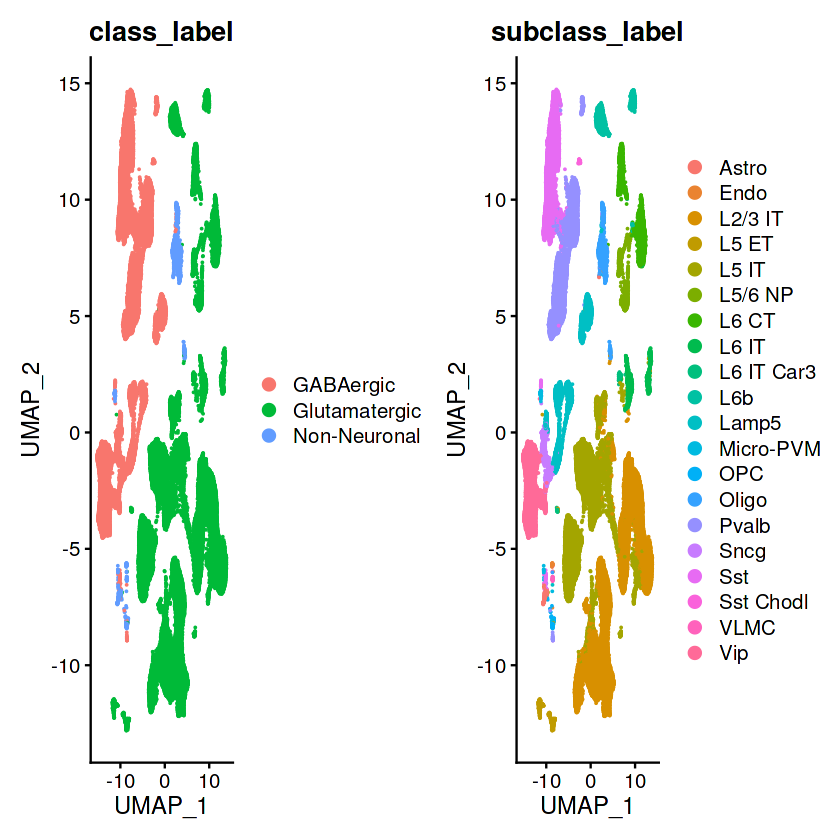

In [45]:
plt<-DimPlot(brainspan, reduction = "umap",group.by=c("class_label","subclass_label"))
plt

In [27]:
brainspan@meta.data[c('class_label','subclass_label','cell_type_alias_label','cell_type_accession_label')]

,class_label,subclass_label,cell_type_alias_label,cell_type_accession_label
,<chr>,<chr>,<chr>,<chr>
AAACCCAAGGATTTCC-LKTX_190129_01_A01,GABAergic,Sst,Inh L1-2 SST CCNJL,CS1912131050
AAACCCAAGTATGGCG-LKTX_190129_01_A01,Glutamatergic,L5/6 NP,Exc L5-6 FEZF2 IFNG-AS1,CS1912131116
AAACCCACAAAGTGTA-LKTX_190129_01_A01,Glutamatergic,L5 IT,Exc L3-5 RORB LINC01202,CS1912131087
AAACCCACACTACTTT-LKTX_190129_01_A01,Glutamatergic,L2/3 IT,Exc L2 LINC00507 GLRA3,CS1912131075
AAACCCACAGTGAGCA-LKTX_190129_01_A01,Non-Neuronal,Oligo,Oligo L2-6 OPALIN FTH1P3,CS1912131120
AAACCCAGTCACCCTT-LKTX_190129_01_A01,Glutamatergic,L6 CT,Exc L5-6 FEZF2 C9orf135-AS1,CS1912131101
AAACCCAGTGTCCACG-LKTX_190129_01_A01,Glutamatergic,L5 ET,Exc L3-5 FEZF2 ASGR2,CS1912131111
AAACCCATCATAAGGA-LKTX_190129_01_A01,Glutamatergic,L5 IT,Exc L3-5 RORB LNX2,CS1912131090
AAACCCATCTGTCCCA-LKTX_190129_01_A01,Glutamatergic,L5 IT,Exc L3-5 RORB LNX2,CS1912131090


In [64]:
# make a new column with cell types given in "cluster_label"
final_cell_types  = sapply(strsplit(brainspan@meta.data[('cluster_label')]$cluster_label, "\\s+"), `[[`, 1)

In [65]:
table(final_cell_types)

final_cell_types
Astro  Endo   Exc   Inh Micro   OPC Oligo  VLMC 
  568    64 48536 23992   108   283  2942    40 

In [66]:
brainspan@meta.data['final_cell_types'] = final_cell_types

In [67]:
brainspan

An object of class Seurat 
32858 features across 76533 samples within 1 assay 
Active assay: RNA (32858 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap

### find anchors via CCA

In [52]:
brainspan.cca.anchors <- FindTransferAnchors(reference = brainspan, query = corces_brain, reduction = 'cca', dims = 1:30, 
                               reference.assay = 'RNA', query.assay = 'RNA', normalization.method = 'LogNormalize')


Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 28018 anchors

Filtering anchors

	Retained 2492 anchors



In [68]:
corces_brain <- TransferData(
  anchorset = brainspan.cca.anchors, 
  reference = brainspan,
  query = corces_brain,
  refdata = list(
    predicted_cell_type = "final_cell_types",
  cluster_label='cluster_label'),
    weight.reduction = 'cca'
)

Finding integration vectors

Finding integration vector weights

Predicting cell labels

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from predictionscorepredicted_cell_type_ to predictionscorepredictedcelltype_"
Warning message:
"Layer counts isn't present in the assay object; returning NULL"
Predicting cell labels

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from predictionscorecluster_label_ to predictionscoreclusterlabel_"
Warning message:
"Layer counts isn't present in the assay object; returning NULL"


In [74]:
colnames(corces_brain@meta.data)

[1] "orig.ident"                          "nCount_peaks"                       
 [3] "nFeature_peaks"                      "total"                              
 [5] "duplicate"                           "chimeric"                           
 [7] "unmapped"                            "lowmapq"                            
 [9] "mitochondrial"                       "nonprimary"                         
[11] "passed_filters"                      "is__cell_barcode"                   
[13] "excluded_reason"                     "TSS_fragments"                      
[15] "DNase_sensitive_region_fragments"    "enhancer_region_fragments"          
[17] "promoter_region_fragments"           "on_target_fragments"                
[19] "blacklist_region_fragments"          "peak_region_fragments"              
[21] "peak_region_cutsites"                "peaks_snn_res.0.8"                  
[23] "seurat_clusters"                     "nCount_RNA"                         
[25] "nFeature_RNA"                        "predicted.predicted_cell_type.score"
[27] "predicted.predicted_cell_type"       "predicted.cluster_label.score"      
[29] "predicted.cluster_label"

In [77]:
corces_brain

An object of class Seurat 
204161 features across 10772 samples within 4 assays 
Active assay: peaks (184419 features, 184419 variable features)
 2 layers present: counts, data
 3 other assays present: RNA, prediction.score.predicted_cell_type, prediction.score.cluster_label
 2 dimensional reductions calculated: lsi, umap

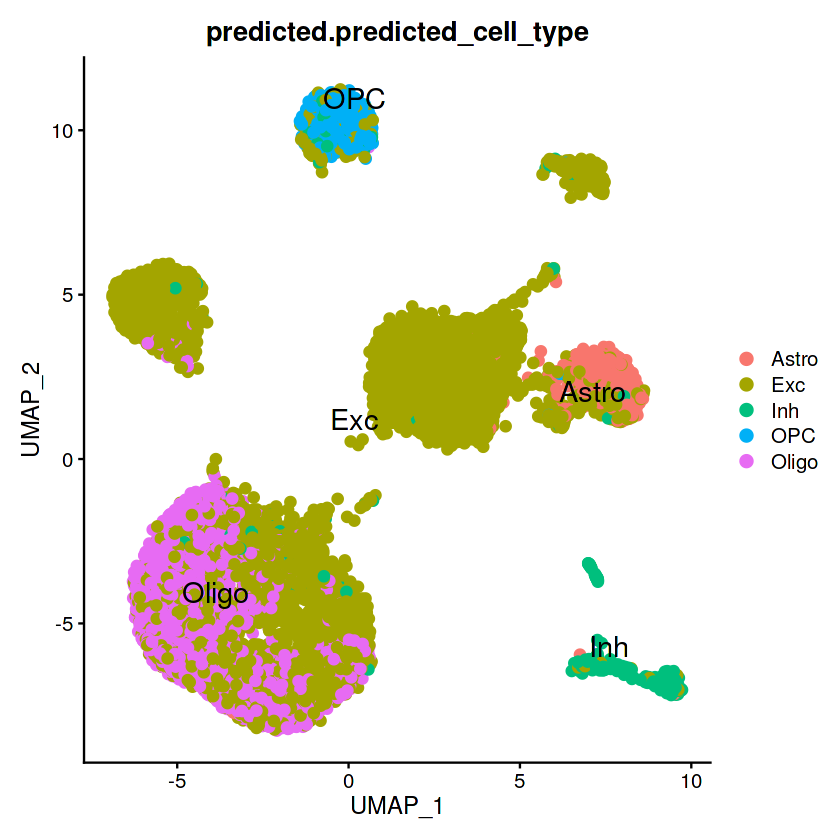

In [81]:
predicted_umap_plot  <- DimPlot(corces_brain, reduction = "umap", group.by = "predicted.predicted_cell_type", label = TRUE, label.size = 6 ,repel = TRUE, pt.size = 2.5)
predicted_umap_plot

In [82]:
predicted_umap_plot_aug <- AugmentPlot(plot = predicted_umap_plot, dpi=500)

In [85]:
figures_dir

[1] "../../../results/Fig8-Corces2020_brain_scATAC/Fig8-apply_seurat_label_transfer/figures/"

In [87]:
ggsave(filename = paste(figures_dir ,"predicted_umap_aug.png", sep=''),predicted_umap_plot_aug)

Saving 6.67 x 6.67 in image


In [88]:
ggsave(filename = paste(figures_dir ,"predicted_umap.png", sep=''),predicted_umap_plot)

Saving 6.67 x 6.67 in image


In [ ]:
brainspan <- FindNeighbors(brainspan)
#brainspan <- FindClusters(brainspan, resolution = 0.5)
brainspan <- RunUMAP(brainspan, dims = 1:14)
plt<-DimPlot(brainspan, reduction = "umap",group.by=c("class_label","subclass_label"))
ggsave(plt,file="allen_brainspan_humancortex.dimplot.pdf",width=30)


In [ ]:
library(Seurat)
library(ggplot2)
#Human
setwd("/home/groups/oroaklab/adey_lab/projects/sciDROP/public_data/allen_brainspan_humancortex")
meta_data<-read.csv("metadata.csv",header=T)
row.names(meta_data)<-meta_data$sample_name
counts<-read.csv("matrix.csv",header=T,row.names=1)
brainspan <- CreateSeuratObject(counts = as.data.frame(t(counts)), project = "brainspain", min.cells = 3, min.features = 500, meta.data=meta_data)
saveRDS(brainspan, file = "allen_brainspan_humancortex.rds")
brainspan <- NormalizeData(brainspan, normalization.method = "LogNormalize", scale.factor = 10000)
brainspan <- FindVariableFeatures(brainspan, selection.method = "vst", nfeatures = 2000)
all.genes <- rownames(brainspan)
brainspan <- ScaleData(brainspan, features = all.genes)
brainspan <- RunPCA(brainspan, features = VariableFeatures(object = brainspan))
plt<-ElbowPlot(brainspan)
ggsave(plt,file="allen_brainspan_humancortex.elbowplot.pdf")
#system("slack -F allen_brainspan_humancortex.elbowplot.pdf ryan_todo")
brainspan <- FindNeighbors(brainspan, dims = 1:14)
brainspan <- FindClusters(brainspan, resolution = 0.5)
brainspan <- RunUMAP(brainspan, dims = 1:14)
plt<-DimPlot(brainspan, reduction = "umap",group.by=c("class_label","subclass_label"))
ggsave(plt,file="allen_brainspan_humancortex.dimplot.pdf",width=30)
#system("slack -F allen_brainspan_humancortex.dimplot.pdf ryan_todo")
saveRDS(brainspan, file = "allen_brainspan_humancortex.rds")

#Mouse
 setwd("/home/groups/oroaklab/adey_lab/projects/sciDROP/public_data/allen_brainspan_mouse")
 meta_data<-read.csv("metadata.csv",header=T)
 row.names(meta_data)<-meta_data$sample_name
 counts<-read.csv("matrix.csv",header=T,row.names=1,nrows=100000) #this is 1million cells, i think 10% of that will be fine, hopefully they are evenly distributed
 brainspan <- CreateSeuratObject(counts = as.data.frame(t(counts)), project = "brainspain", min.cells = 3, min.features = 500, meta.data=meta_data)
 saveRDS(brainspan, file = "allen_brainspan_mouse.rds")
 brainspan <- NormalizeData(brainspan, normalization.method = "LogNormalize", scale.factor = 10000)
 brainspan <- FindVariableFeatures(brainspan, selection.method = "vst", nfeatures = 2000)
 all.genes <- rownames(brainspan)
 brainspan <- ScaleData(brainspan, features = all.genes)
 brainspan <- RunPCA(brainspan, features = VariableFeatures(object = brainspan))
 plt<-ElbowPlot(brainspan)
 ggsave(plt,file="allen_brainspan_mouse.elbowplot.pdf")
 #system("slack -F allen_brainspan_mouse.elbowplot.pdf ryan_todo")
 brainspan <- FindNeighbors(brainspan, dims = 1:15)
 brainspan <- FindClusters(brainspan, resolution = 0.5)
 brainspan <- RunUMAP(brainspan, dims = 1:15)
 plt<-DimPlot(brainspan, reduction = "umap",group.by=c("class_label","subclass_label"))
 ggsave(plt,file="allen_brainspan_mouse.dimplot.pdf",width=30)
 #system("slack -F allen_brainspan_mouse.dimplot.pdf ryan_todo")
 saveRDS(brainspan, file = "allen_brainspan_mouse.rds")





In [5]:

# extract gene annotations from EnsDb
hg38_annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86)

Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warn

In [6]:
#Read in fragment path for coverage plots
hg38_fragment.path="../../../data/Zhang2024_txciATAC_10k/01_prepare_fragments_file/GSM7852212_hg38.merged_correct_sorted_10k_fragments.tsv.gz"
#hg38_fragment.path="../../../data/Zhang2024_txiATAC/01_prepare_fragments_file/final_fragment_files/GSM7852212_hg38_merged_no_chrMt_sorted_fragments.tsv.gz"


In [7]:
seqlevelsStyle(hg38_annotations) <- 'UCSC'

In [21]:
seqlevels(hg38_annotations)

[1] "chrX"  "chr20" "chr1"  "chr6"  "chr3"  "chr7"  "chr12" "chr11" "chr4" 
[10] "chr17" "chr2"  "chr16" "chr8"  "chr19" "chr9"  "chr13" "chr14" "chr5" 
[19] "chr22" "chr10" "chrY"  "chr18" "chr15" "chr21" "chrM"

In [22]:
Seqinfo(genome="hg38")

Seqinfo object with 711 sequences (1 circular) from hg38 genome:
  seqnames             seqlengths isCircular genome
  chr1                  248956422      FALSE   hg38
  chr2                  242193529      FALSE   hg38
  chr3                  198295559      FALSE   hg38
  chr4                  190214555      FALSE   hg38
  chr5                  181538259      FALSE   hg38
  ...                         ...        ...    ...
  chr22_KQ759761v1_alt     145162      FALSE   hg38
  chrX_KV766199v1_alt      188004      FALSE   hg38
  chrX_MU273395v1_alt      619716      FALSE   hg38
  chrX_MU273396v1_alt      294119      FALSE   hg38
  chrX_MU273397v1_alt      330493      FALSE   hg38

In [8]:
#Generate ChromatinAssay Objects
hg38_brain_chromatinassay <- CreateChromatinAssay(
  counts = hg38_counts,
  genome="hg38",
  min.cells = 1,
  annotation=hg38_annotations,
  sep=c("_","_"),
  fragments=hg38_fragment.path
)

Computing hash



In [9]:
hg38_brain_chromatinassay

ChromatinAssay data with 332864 features for 28663 cells
Variable features: 0 
Genome: hg38 
Annotation present: TRUE 
Motifs present: FALSE 
Fragment files: 1 

In [10]:
#Create Seurat Objects
brainCortex.atac <- CreateSeuratObject(
  counts = hg38_brain_chromatinassay,
  assay = "peaks"
)

In [11]:
brainCortex.atac <- NucleosomeSignal(brainCortex.atac)
brainCortex.atac <- TSSEnrichment(brainCortex.atac)

Extracting TSS positions

Extracting fragments at TSSs

Warning message in n * (seq_along(along.with = reads)):
"NAs produced by integer overflow"
Warning message in n * (seq_along(along.with = reads)):
"NAs produced by integer overflow"
Warning message in n * (seq_along(along.with = reads)):
"NAs produced by integer overflow"
Warning message in n * (seq_along(along.with = reads)):
"NAs produced by integer overflow"
Warning message in n * (seq_along(along.with = reads)):
"NAs produced by integer overflow"


ERROR: Error in base::rowSums(x, na.rm = na.rm, dims = dims, ...): 'x' must be an array of at least two dimensions
